In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
run 'clean_data.py'

In [4]:
monthly_df = df

In [5]:
df = df.drop(df.columns[[1,2]], axis=1)

In [9]:
df.head()

,year,latitude,longitude,temperature,oxygen
39,1984,80.7333,12.8533,-0.8198,400.4
41,1984,80.7333,12.8533,-0.8118,347.7
42,1984,80.7333,12.8533,1.5336,315.0
43,1984,80.7333,12.8533,2.3164,317.6
44,1984,80.7333,12.8533,2.8303,314.1


In [6]:
surface = df[df['depth']<=20]

In [7]:
surface.head()

,year,latitude,longitude,depth,temperature,oxygen
39,1984,80.7333,12.8533,3.0,-0.8198,400.4
58,1984,80.9050,18.5883,5.0,2.3114,386.9
59,1984,80.9050,18.5883,18.0,1.2787,382.5
66,1984,81.0517,17.6683,6.0,1.7416,372.3
82,1984,81.1967,16.7933,4.0,-0.7188,398.3


# EDA

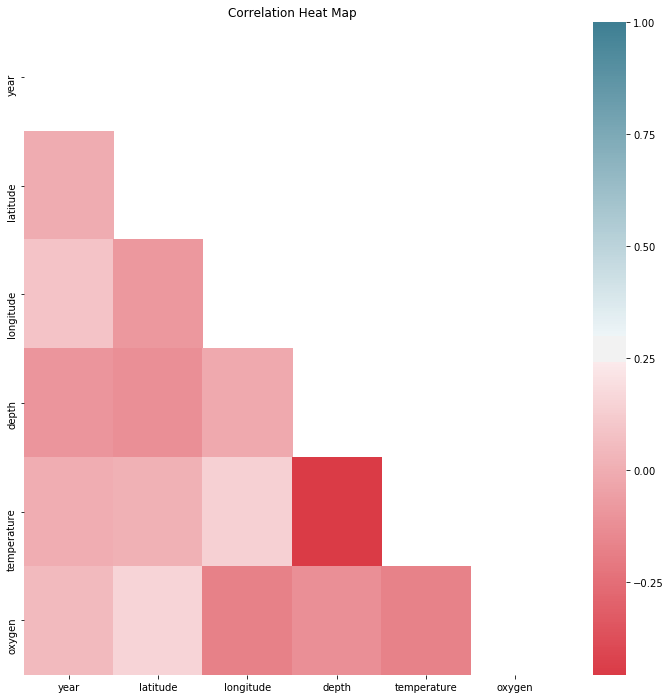

In [8]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap)
ax.set_title("Correlation Heat Map")

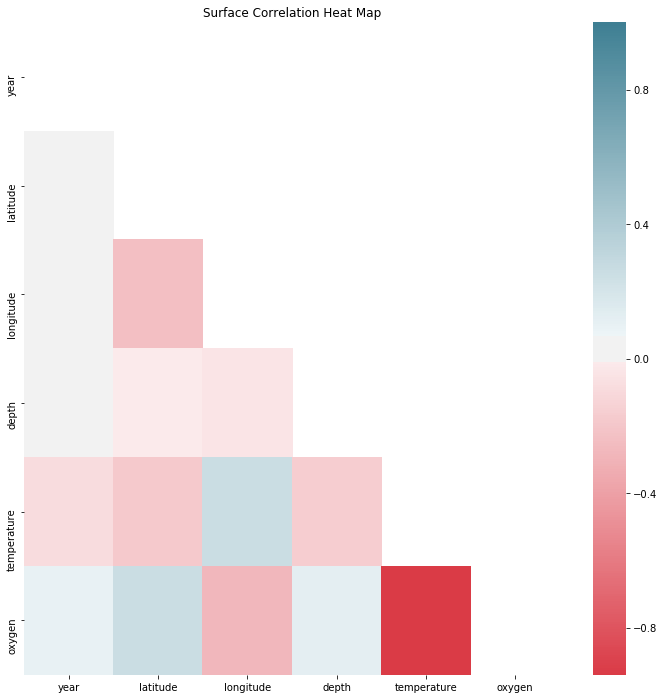

In [29]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(surface.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(surface.corr(), mask=mask, cmap=cmap)
ax.set_title("Surface Correlation Heat Map")

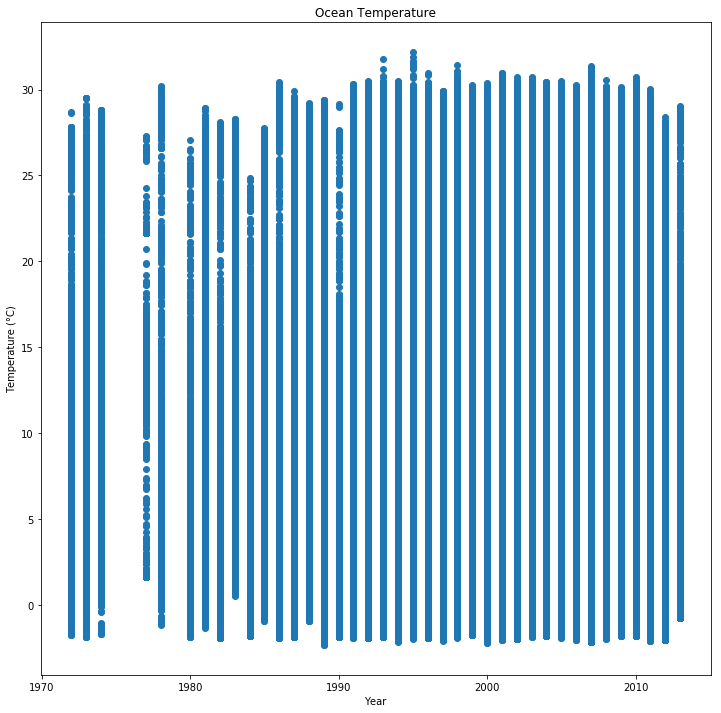

In [33]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Ocean Temperature')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.scatter(df['year'], df['temperature'])

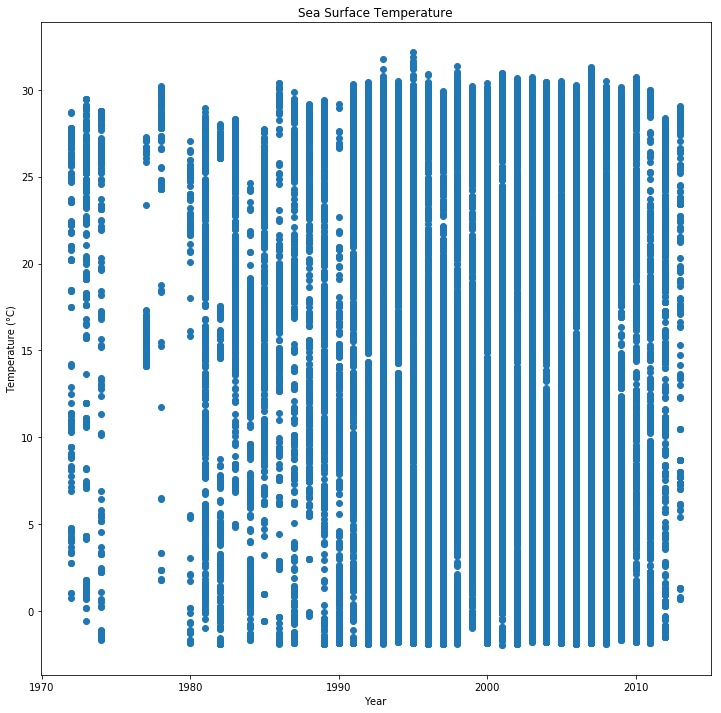

In [32]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Sea Surface Temperature')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.scatter(surface['year'], surface['temperature'])

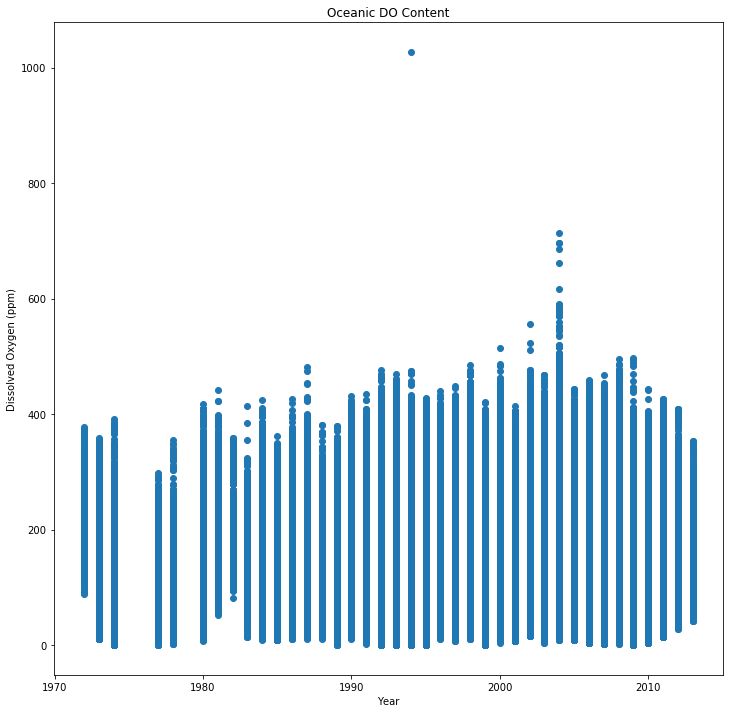

In [30]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Oceanic DO Content')
ax.set_xlabel('Year')
ax.set_ylabel('Dissolved Oxygen (ppm)')
ax.scatter(df['year'], df['oxygen'])

### What is that outlier?

In [ ]:
df[df['oxygen']>800]

### Let's keep it!

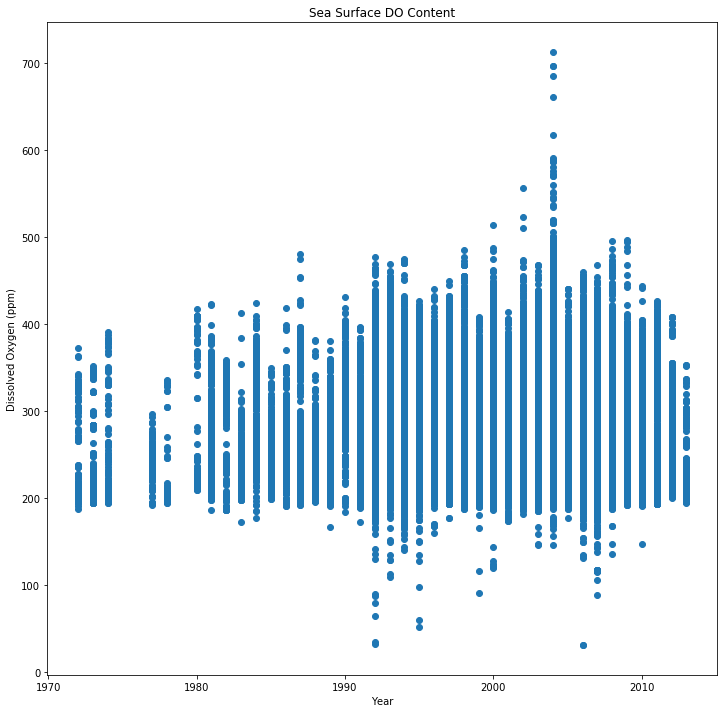

In [31]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Sea Surface DO Content')
ax.set_xlabel('Year')
ax.set_ylabel('Dissolved Oxygen (ppm)')
ax.scatter(surface['year'], surface['oxygen'])

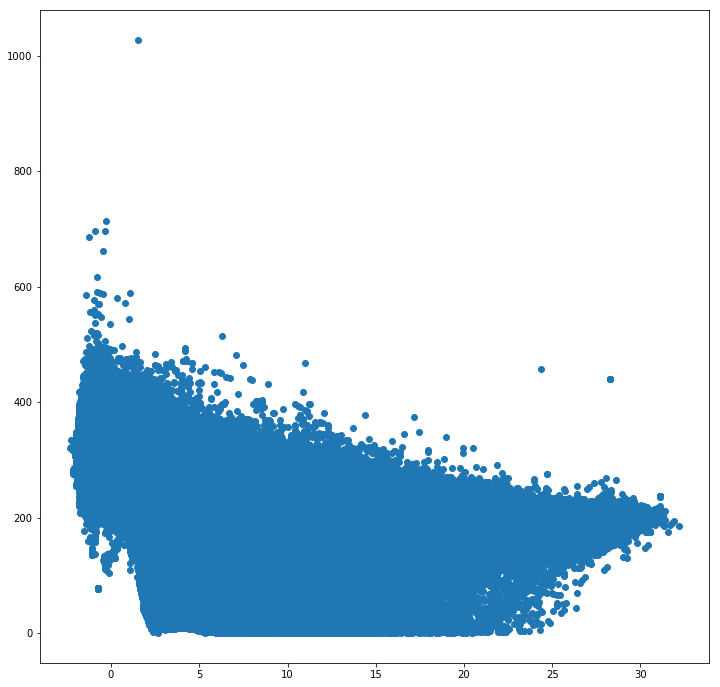

In [23]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.scatter(df['temperature'], df['oxygen'])

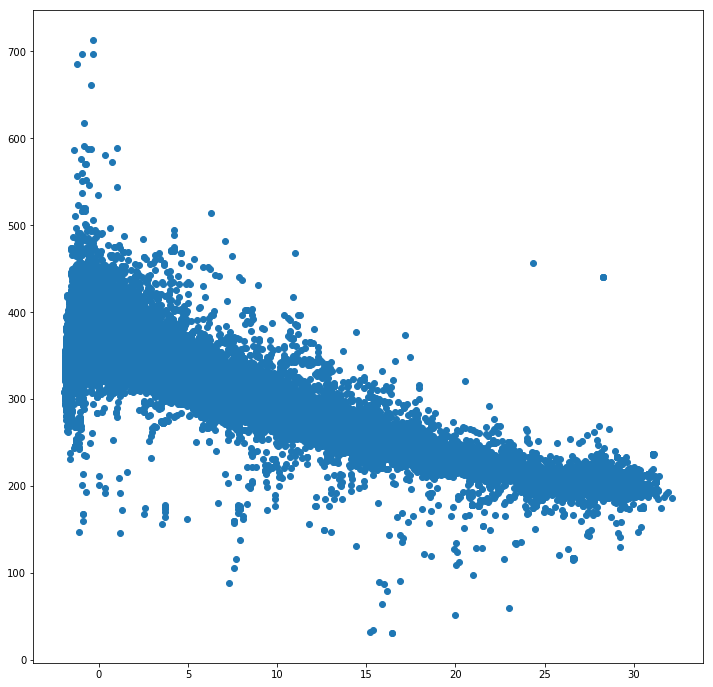

In [24]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(surface['temperature'], surface['oxygen'])

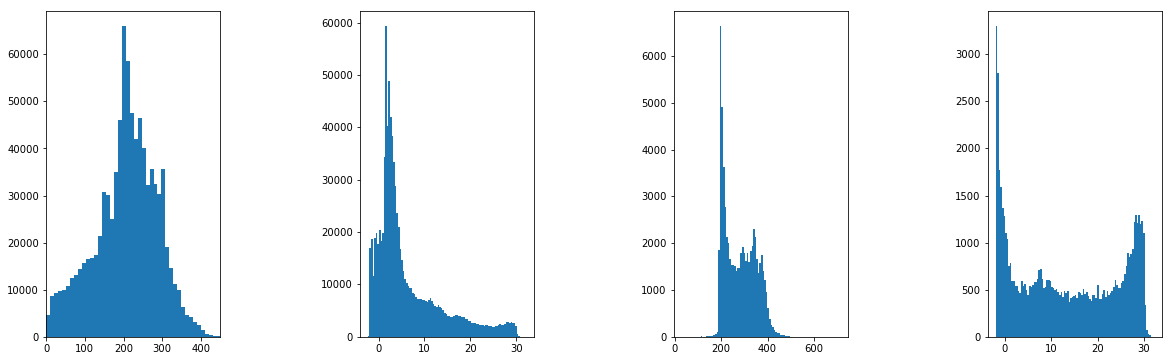

In [25]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(141)
ax.set_xlim(0, 450)
ax.hist(df['oxygen'], bins=100)

ax2 = fig.add_subplot(142)
ax2.hist(df['temperature'], bins=100)

ax3 = fig.add_subplot(143)
ax3.hist(surface['oxygen'], bins=100)

ax4 = fig.add_subplot(144)
ax4.hist(surface['temperature'], bins=100)
fig.subplots_adjust(wspace=0.8)

### Scatter Matrix

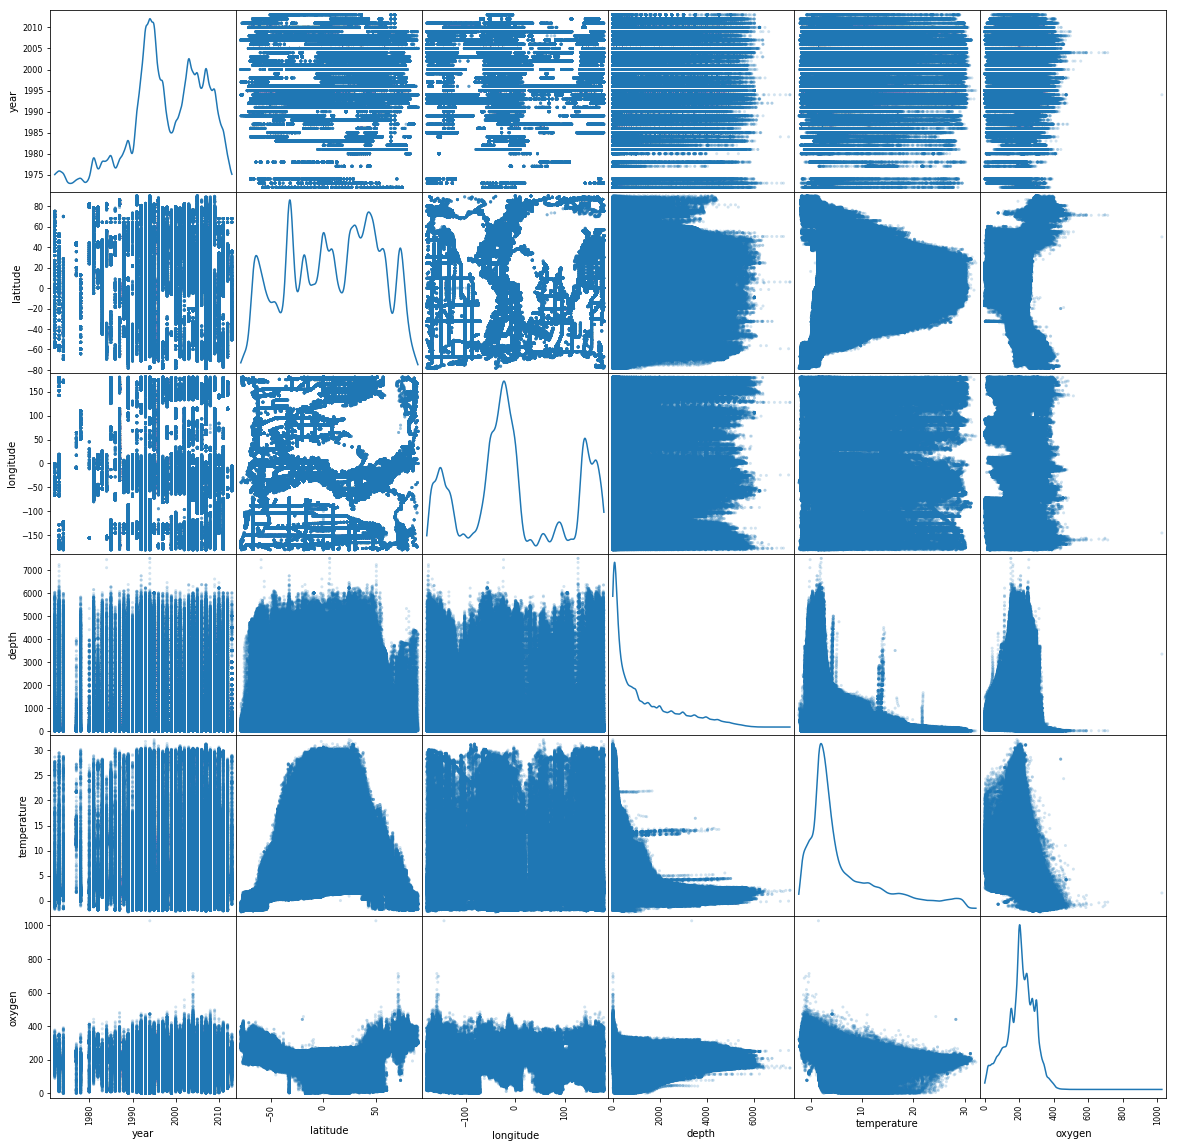

In [26]:
_ = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')

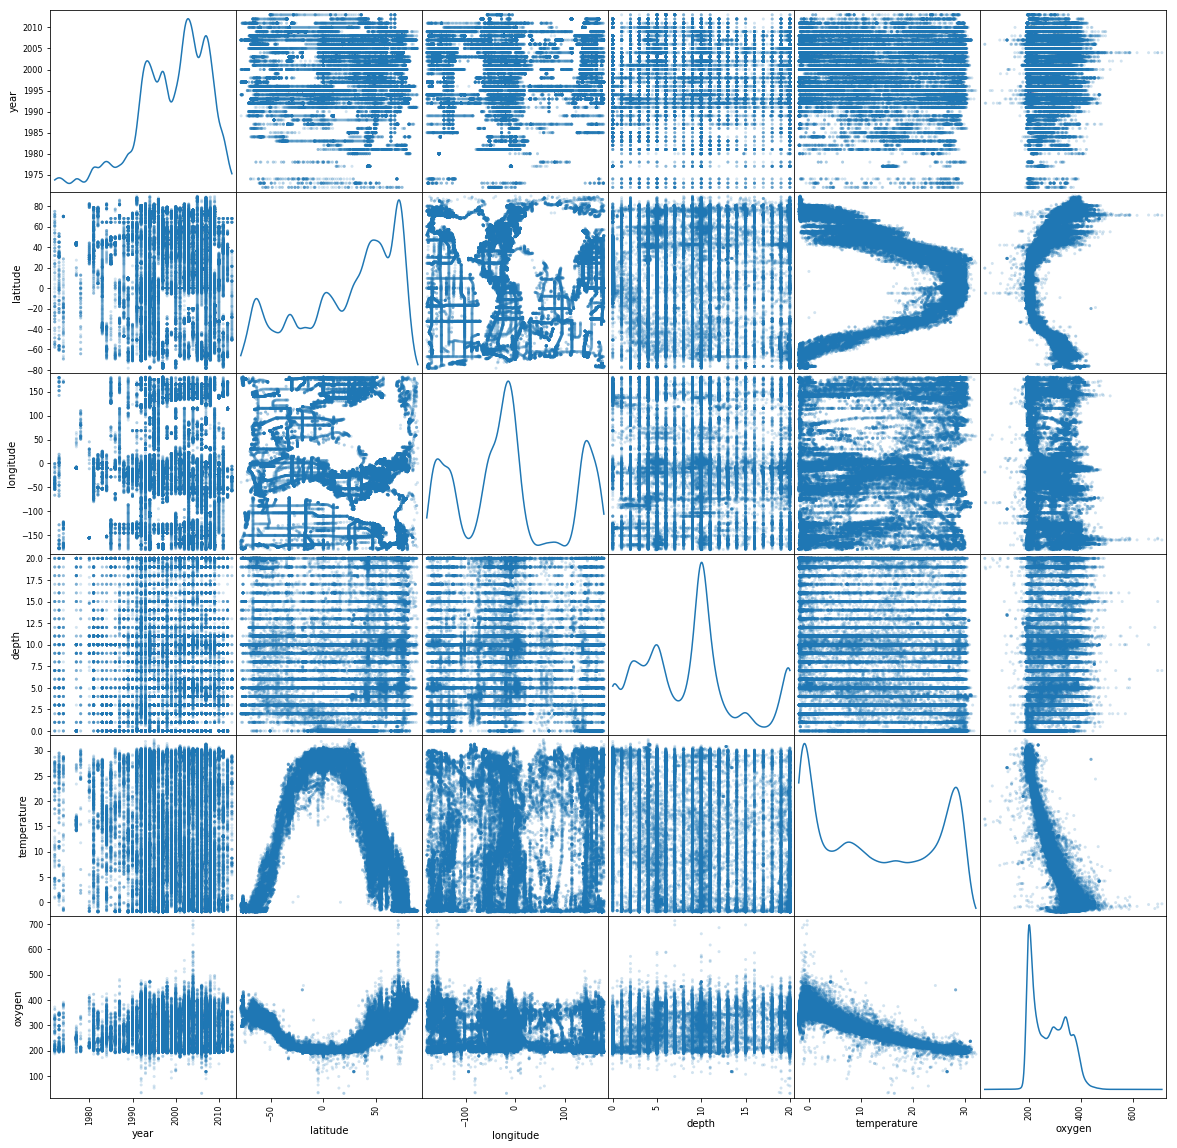

In [28]:
_ = pd.plotting.scatter_matrix(surface, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [61]:
surftemp = surface[['year','temperature']]

In [62]:
surftempbyyr = surftemp.groupby(['year'], as_index=False).mean()

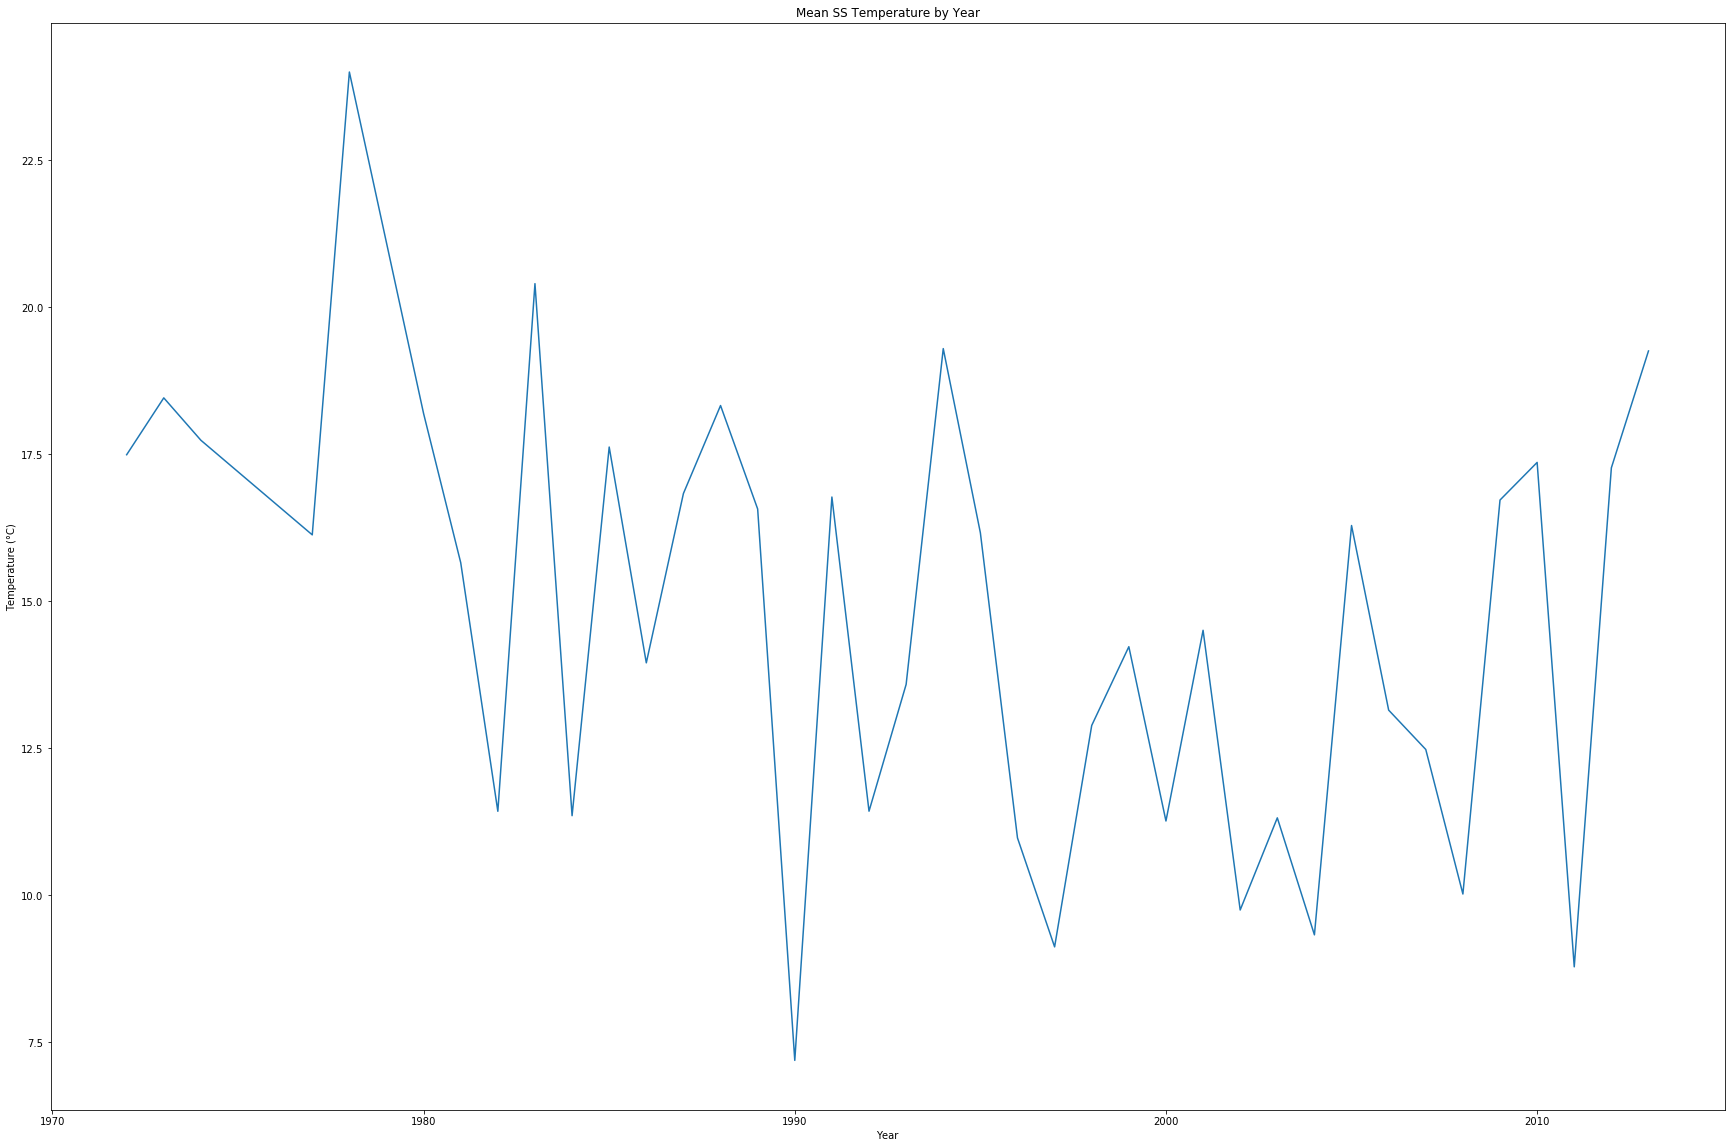

In [64]:
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)
ax.set_title('Mean SS Temperature by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.plot(surftempbyyr['year'], surftempbyyr['temperature'])

## Exploring Summer

In [5]:
northern = monthly_df[monthly_df['latitude']>23.5]
southern = monthly_df[monthly_df['latitude']<-23.5]

In [6]:
northern_summer = northern.query('6 <= month <= 8')

In [7]:
southern_summer = southern[(southern['month']==12) | (southern['month']==1) | (southern['month']==2)]

In [98]:
summer = pd.concat([northern_summer, southern_summer])

In [99]:
summer_means = summer.groupby(['year'], as_index=False).mean()

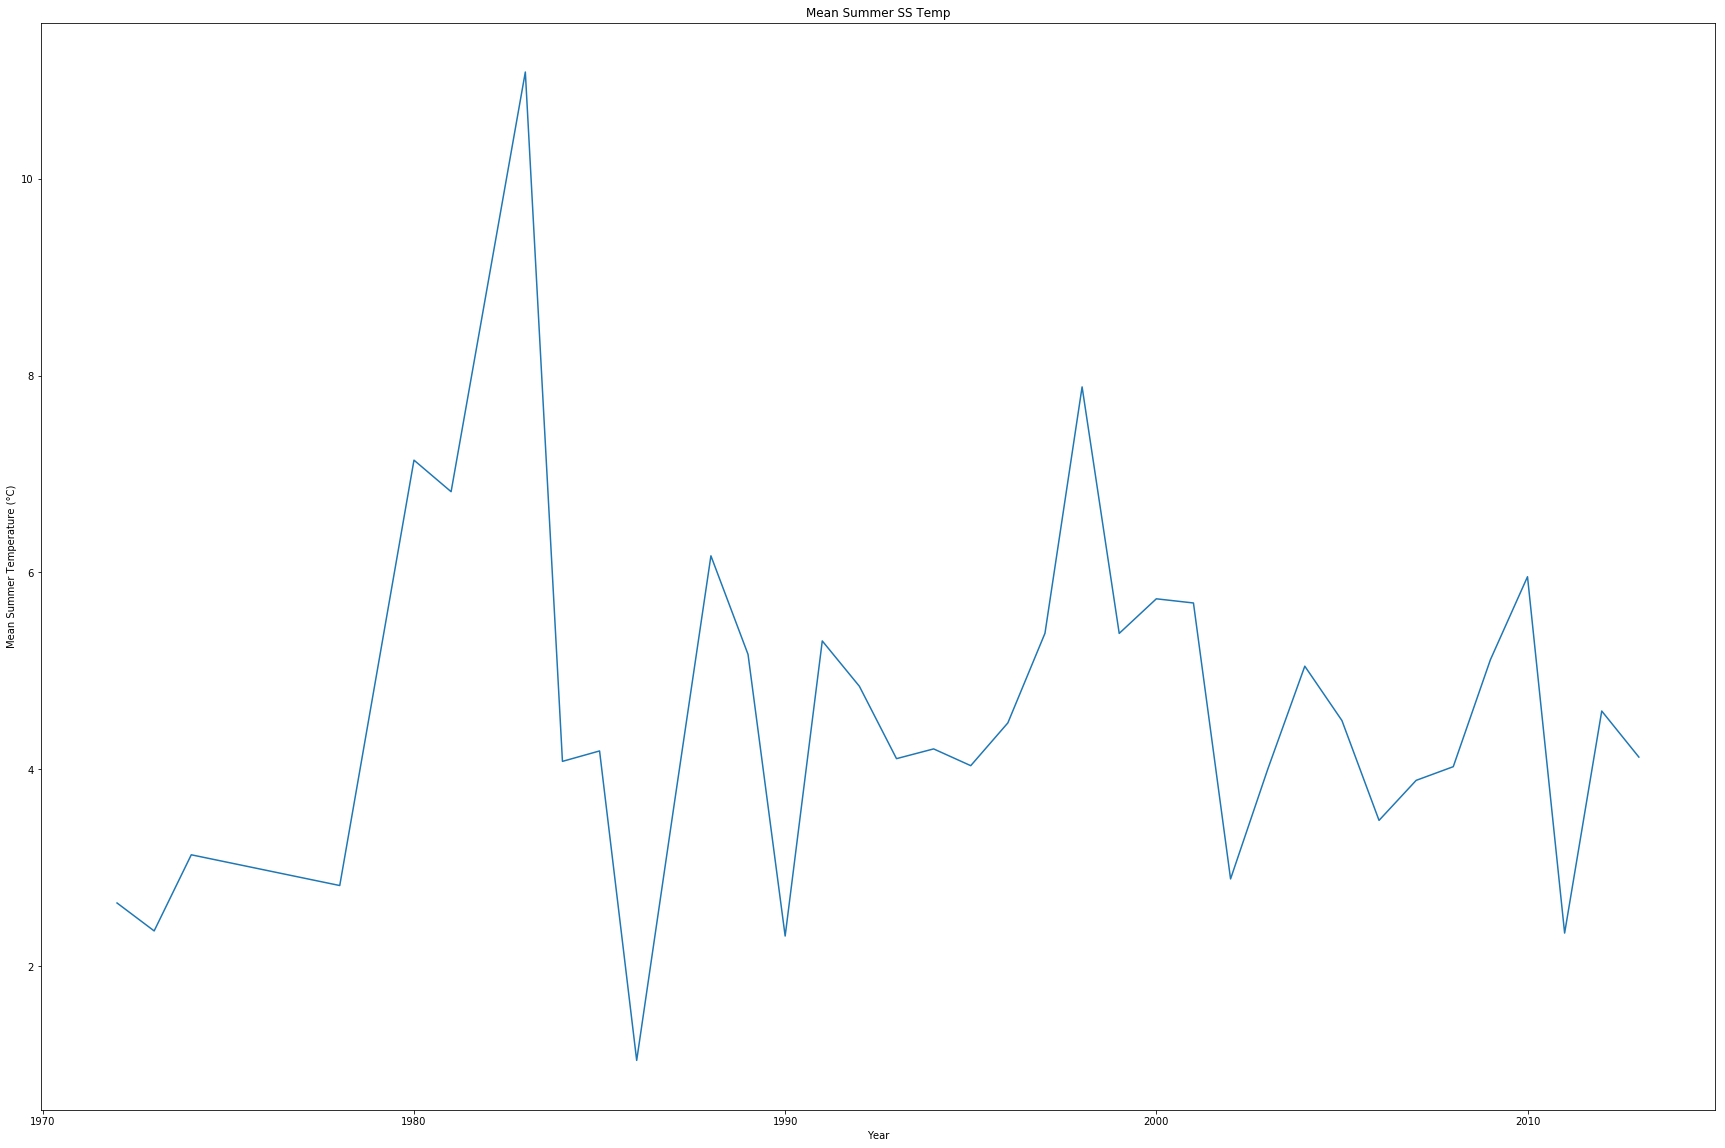

In [100]:
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)
ax.set_title('Mean Summer SS Temp')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Summer Temperature (°C)')
ax.plot(summer_means['year'], summer_means['temperature'])

In [11]:
southern_winter = southern.query('6 <= month <= 8')

In [12]:
northern_winter = northern[(northern['month']==12) | (northern['month']==1) | (northern['month']==2)]

In [101]:
winter = pd.concat([northern_winter,southern_winter])

In [102]:
winter_means = winter.groupby(['year'], as_index=False).mean()

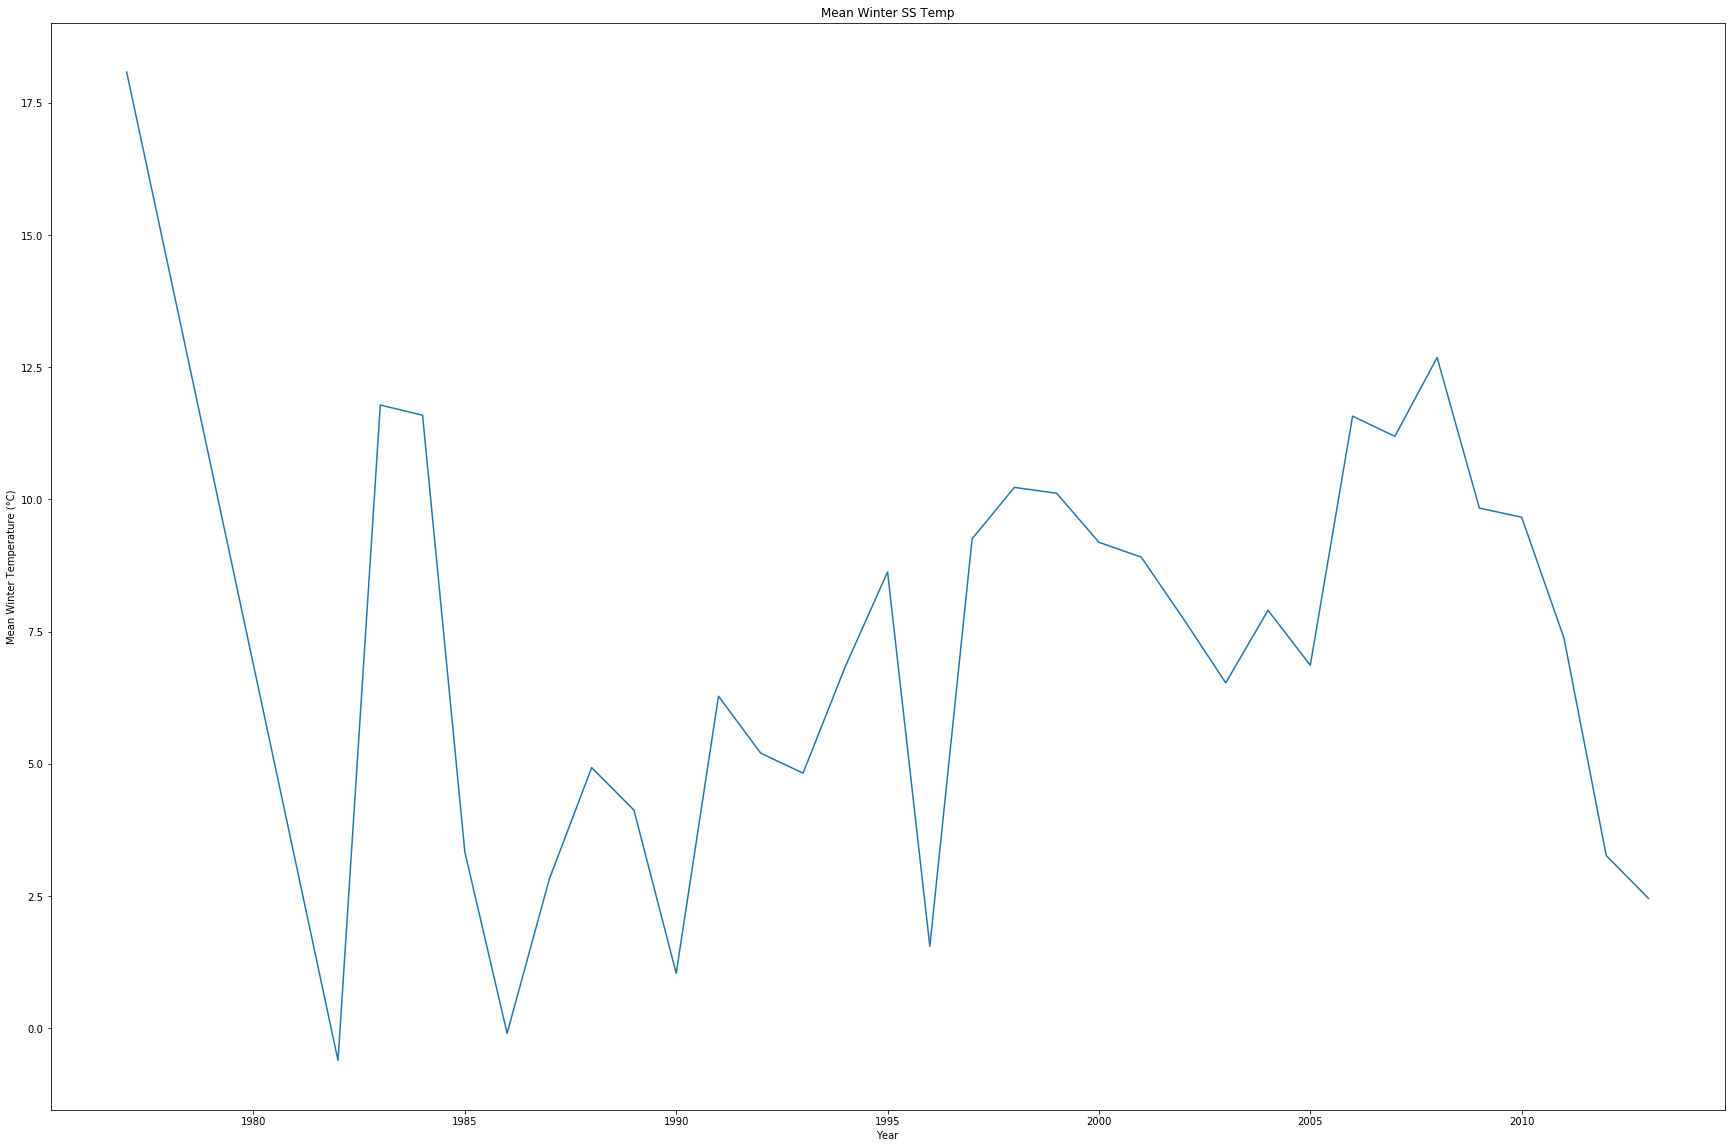

In [103]:
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)
ax.set_title('Mean Winter SS Temp')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Winter Temperature (°C)')
ax.plot(winter_means['year'], winter_means['temperature'])

### Welch's t-test: 1990s vs 2000s

In [111]:
df_90s = winter.query('1990 <= year <= 1999')
df_00s = winter.query('2000 <= year <= 2009')

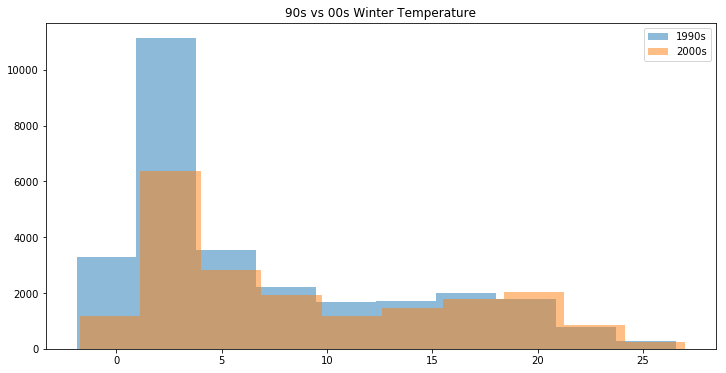

In [130]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_title('90s vs 00s Winter Temperature')
ax1 = ax.hist(df_90s['temperature'], alpha=0.5, label='1990s')
ax2 = ax.hist(df_00s['temperature'], alpha=0.5, label='2000s')
ax3 = ax.axvline(df_90s['temperature'].mean(), alpha=0.6, lw=2)
ax.legend()

In [112]:
stats.ttest_ind(df_90s['temperature'],df_00s['temperature'], equal_var=False)

Ttest_indResult(statistic=-30.720463707190444, pvalue=6.6439678375408638e-205)

In [113]:
df_90s_summer = summer.query('1990 <= year <= 1999')
df_00s_summer = summer.query('2000 <= year <= 2009')

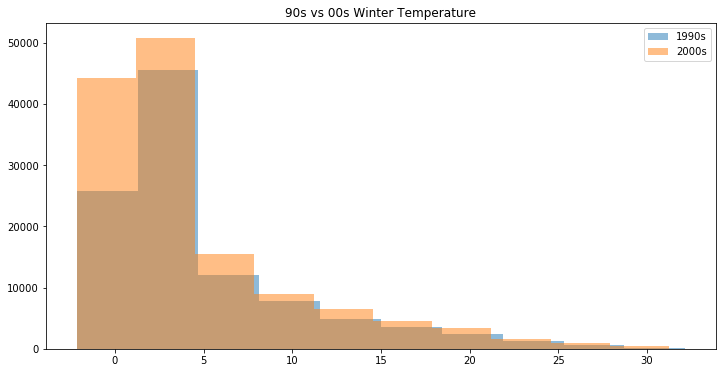

In [131]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_title('90s vs 00s Winter Temperature')
ax1 = ax.hist(df_90s_summer['temperature'], alpha=0.5, label='1990s')
ax2 = ax.hist(df_00s_summer['temperature'], alpha=0.5, label='2000s')
ax.legend()

In [115]:
stats.ttest_ind(df_90s_summer['temperature'],df_00s_summer['temperature'], equal_var=False)

Ttest_indResult(statistic=16.552494534109371, pvalue=1.6692202110228927e-61)

In [ ]:
fig = plt.figure(figsize=(12,6))
win90smean= df_90s['temperature'].mean()
win00smean= df_00s['temperature'].mean()
p_val = stats.ttest_ind(win90smean, win00smean, equal_var=False)
